# Detecting and Classifying Water Slicks on Lake Geneva

## Structure
1. Balance Dataset
2. Computer Vision Feature Extraction
3. Feature Exngineering
4. Machine Learning Models Comparison
5. Error Space Analysis
6. Unsupervised Slicks Classification

### Import Libraries

In [34]:
# importing the libraries
import imageio 
import os
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import ndimage as ndi
from skimage import filters, feature, exposure
from skimage.filters import sobel
from skimage.segmentation import watershed 
import matplotlib.cm as cm
from tqdm import tqdm

import random
import math
import pandas as pd 
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from matplotlib.pyplot import figure
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression 
from bisect import bisect_left

### 1. Balance Dataset

In [2]:
# giving directory name
root_dir = './dataset/' 

def get_imgs_paths_from_folder(folder_dir):
    """
    Extract all images path from given folder

    Parameters
    ----------
    folder_dir: str
        path to directory of folder
    Returns
    -------
    array
        List of images path
    """
    # giving file extension
    ext = ('.jpeg', '.jpg')

    # saving all path to images
    img_paths = [] 

    for file in os.listdir(folder_dir):
        # skip if do not ends with ext
        if not file.lower().endswith(ext):
            continue 
        impath = os.path.join(folder_dir, file) 
        # skip if not file
        if not os.path.isfile(impath):
            continue   
        # add to our list
        img_paths.append(impath) 
    return img_paths

In [83]:
# directories with no slicks
dirs_no_slicks = ['2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04']
# directories with slicks(same as with no slicks, but ends with _slicks)
dirs_slicks = [dir_slick+str('_slicks') for dir_slick in dirs_no_slicks] 
# images path with slicks
img_paths_slicks = [img for curr_dir in dirs_slicks for img in get_imgs_paths_from_folder(curr_dir)]
# extract images path length for balancing
img_path_lens = [len(get_imgs_paths_from_folder(curr_dir)) for curr_dir in dirs_slicks]
# images path with no slicks - balanced
img_folder_no_slicks = [img for i, curr_dir in enumerate(dirs_no_slicks) 
                        for img in random.sample(get_imgs_paths_from_folder(curr_dir),img_path_lens[i])]

In [84]:
# creating dataframe
df = pd.DataFrame({"img": img_paths_slicks + img_folder_no_slicks, 
                   "label": [1]*len(img_paths_slicks)
                           +[0]*len(img_folder_no_slicks)})
df.sample(3)

,img,label
1901,2020-10\2020-10-03_14-30.jpeg,0
1255,2021-04_slicks\2021-04-02_08-30.jpeg,1
1807,2020-10\2020-10-27_16-10.jpeg,0


---

### 2. Computer Vision Feature Extraction

In [188]:
def calc_diag(all_slicks, groups): 
    """
    Calulate mean diagonal of outer rectangle of slick

    Parameters
    ----------
    all_slicks: matrix
        matrix of separate slicks
    groups: array
        slicks for which diag should be caclulated
    Returns
    -------
    float
        Average diagonal for group of slicks
    """
    diag = []
    # iterate thorough all groups
    for g in groups: 
        # calculate outer rectangle coords
        tmp = np.argwhere(all_slicks == g)
        a1 = np.min(tmp[:, 0])
        a2 = np.max(tmp[:, 0])
        b1 = np.min(tmp[:, 1])
        b2 = np.max(tmp[:, 1])
        # calculate diagonal
        d = np.round(np.sqrt(pow(a2-a1, 2) + pow(b2-b1, 2)), 2)
        # add to list
        diag.append(d) 
#     print(max(diag) if diag != [] else 0)
    c = histogram(diag, bins) 
    return np.mean(np.array(diag)) if len(diag) > 0 else 0, c

In [ ]:
# features to be added
# total surface of slick
fil_surface = [] 
# total number of slicks
fil_number = [] 
# mean diagonal of outer rectangle of slicks
fil_diag = [] 
# histogram of diagonal of outer rectangle of slicks
fil_diag_bins = [] 
# histogram of surface of slicks
fil_sizes_bins = [] 
 
for i in range(len(df)):
    # read grayscale image
    img = cv2.imread(df.img[i], cv2.IMREAD_GRAYSCALE)  
    # extract egdes adjusting log
    adjust_logs = exposure.adjust_log(img, gain=1, inv=False)
    # perform hessian
    _, _, Hcc = feature.hessian_matrix(adjust_logs, sigma = 3)
    # filter hessian matrix and crop upper and lower part (noise)
    hess_filtered = (1 - (Hcc > 0.45*Hcc.mean())).astype(int)[20:-20]  
    # label all separate slicks
    label_objects, nb_labels = ndi.label(hess_filtered)
    # calculate sizes
    sizes = np.bincount(label_objects.ravel())
    # filter slicks with small surface (denoise)
    mask_sizes = (sizes > 150) 
    mask_sizes[0] = 0 
    # get cleaned slicks
    slicks_cleaned = mask_sizes[label_objects] 
    # take all slicks that belong to group
    groups = np.argwhere(mask_sizes == True).reshape(-1)
     
    # calculate mean diagonal of extracted slicks
    diag, diag_bins = calc_diag(label_objects, groups)
    
    # append features
    fil_surface.append(sum(sum(slicks_cleaned)))
    fil_number.append(sum(mask_sizes)) 
    fil_diag.append(diag)
    fil_diag_bins.append(diag_bins)
#     fil_surface_bins.append(histogram(sizes, bins_surf)[1:]) 
    fil_sizes_bins.append(sizes) 
# add extracted fatures to dataframe
df["fil_diag"] = fil_diag
df["fil_surface"] = fil_surface
df["fil_number"] = fil_number
    

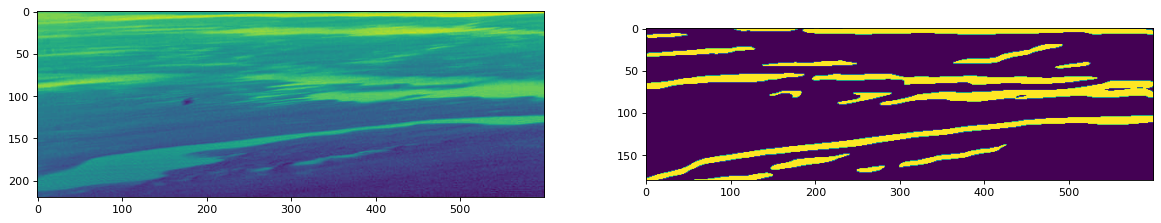

In [172]:
figure(figsize=(18, 8), dpi=80) 
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(slicks_cleaned)

### 3. Feature Engineering

In [440]:
# add scaled surface (total surface divided by mean diagonal)
df["scaled_surf"] = df["fil_surface"]/df["fil_diag"]
# add different of surface of outer circle and total surface
df["percent_surf"] = -df["fil_surface"]+pow(df["fil_diag"], 2)/4*np.pi
# clean nans
df = df.fillna(0)

In [442]:
# extract X and y
features = ["fil_surface", "fil_diag", "fil_number", "scaled_surf", "percent_surf"] 
X = df[features]
y = df["label"]  

---

### 4. Machine Learning Models Comparison

In [443]:
def get_metrics(X, y, test_size):
    """
    Fill dataframe with metrics of different classifiers

    Parameters
    ----------
    X: array
        array of input features
    y: array
        array of labels
    test_size: float
        size of test set
    Returns
    -------
    pd.DataFrame
        output dataframe with all metrics
    """
    # split data to train and test
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=43, test_size = test_size) 
    # all diferent classifiers to be used
    switcher = {'log': 
                make_pipeline(StandardScaler(), LogisticRegression()),
                'rf': 
                RandomForestClassifier(max_depth=4, random_state=0),
                'gnb':
                GaussianNB(),
                'svm':
                make_pipeline(StandardScaler(), SVC(gamma='auto'))
               } 
    # names of all classifiers
    logger = {  'log': 'Logistic Regression',
                'rf': 'Radnom Forest Classifier',
                'gnb': 'Gaussian Naive Bayes Classifier',
                'svm': 'Suport Vector Machine'
             }
    # all modes
    mode = ['log', 'rf', 'gnb', 'svm']
    # empty dataframe
    df = pd.DataFrame(data = {'Classifier': ["Precission", "Recall", "Accuracy", "F1"]})
    # iterate though modes
    for m in mode:
        # fit the data
        clf =  switcher[m].fit(X_train, y_train)
        # predict test values
        y_pred = clf.predict(X_test) 
        # extract metrics (precission, recall, accuracy and F1)
        cm = confusion_matrix(y_test, y_pred) 
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        prec = (tp)/(tp+fp)
        recall = (tp)/(tp+fn)
        acc = (tp+tn)/(tp+fp+tn+fn)
        f1 = 2*prec*recall / (prec + recall) 
        # add metrics to dataframe
        df.loc[:,logger[m]] = [np.round(100*prec,2), np.round(100*recall,2),
                  np.round(100*acc, 2), np.round(100*f1, 2)]
    # set classifier as index
    df.set_index("Classifier", inplace = True)
    return df

In [444]:
get_metrics(X, y, test_size = 0.3).transpose()

Classifier,Precission,Recall,Accuracy,F1
Logistic Regression,76.02,77.45,77.13,76.73
Radnom Forest Classifier,77.05,80.58,78.86,78.78
Gaussian Naive Bayes Classifier,78.73,72.65,77.13,75.57
Suport Vector Machine,77.46,78.91,78.56,78.18


### 5. Error Space Analysis

In [138]:
# took random forest classifier as we see that it has 
# the best performance to check error space analysis
clf =  RandomForestClassifier(max_depth=5, random_state=0).fit(X, y)
df["test_label"] = clf.predict(X) 

,img,label,fil_diag,fil_surface,fil_number,scaled_surf,percent_surf,test_label
1890,2020-10\2020-10-06_12-30.jpeg,0,64.445,478,2,7.417177,2783.882685,0
1078,2021-03_slicks\2021-03-08_07-30.jpeg,1,55.186,1007,5,18.247382,1384.925862,0
1845,2020-10\2020-10-11_17-07.jpeg,0,0.000,0,0,0.000000,0.000000,0


In [472]:
def show_imgs_5x4(img_paths, title):
    """
    Show images in 5x4 subplot

    Parameters
    ----------
    img_paths: array
        array of images path 
    Returns
    -------
    """
    # set figure size
    figure(figsize=(12, 12))   
    # iterate for 5x4 subplots
    for i in range(5):
        for j in range(4): 
            # read images grayscale and plot it
            img = cv2.imread(img_paths[4*i+j - 1], cv2.IMREAD_GRAYSCALE) 
            plt.subplot2grid((5,4), (i,j))
            plt.imshow(img)   
            plt.title(title)
    plt.show()

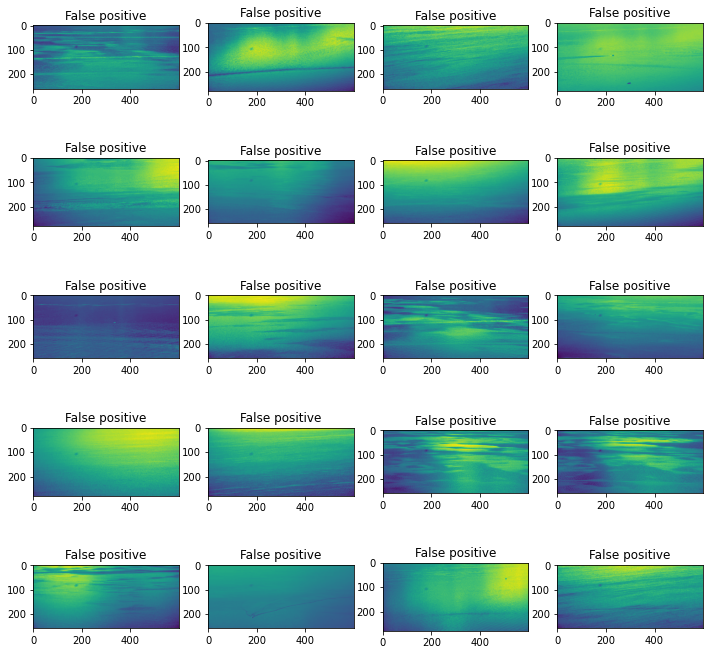

In [473]:
# extract false positive image paths
img_paths_fp = df[(df.label == 0) & (df.test_label == 1)][:20].img.values
show_imgs_5x4(img_paths_fp, "False positive")

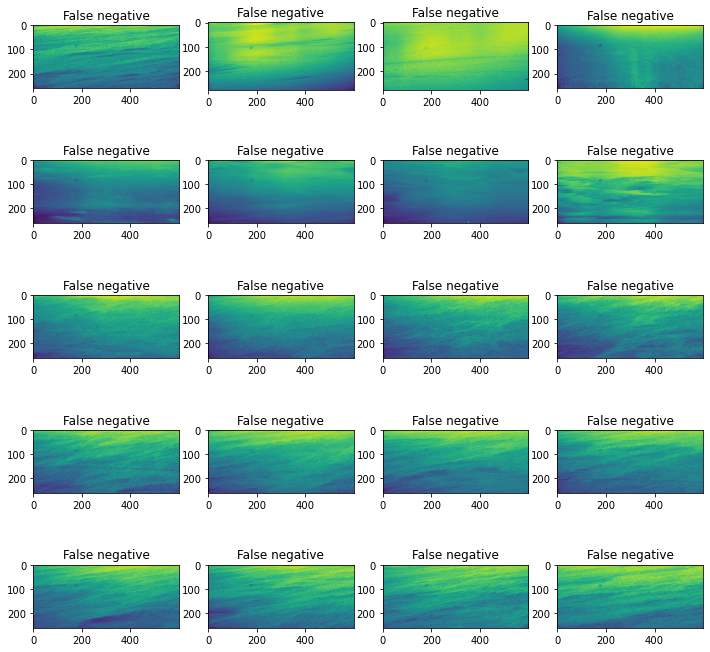

In [474]:
# extract false negative image paths
img_paths_fn = df[(df.label == 1) & (df.test_label == 0)][:20].img.values
show_imgs_5x4(img_paths_fn, "False negative")

### 6. Unsupervised Slicks Classification

In [475]:
# adding additional features
def histogram(values, dividers):
    """
    Put values in bins by dividers

    Parameters
    ----------
    values: array
        array of input values 
    dividers: array
        array of boundaries
    Returns
    -------
    count: array
        array of counts by bins
    """
    count = [0]*(1+len(dividers))
    # for every value
    for element in values:
        # caluclate bins 
        i = bisect_left(dividers, element)
        count[i] += 1
    return count 

# empirically set boundaries for bins for diagonal
bins_diag = []
for i in range(9):
    bins_diag.append((i+1)*60)  
# empirically set boundaries for bins for surface
bins_surf = []
for i in range(10):
    bins_surf.append((i+1)*150) 

In [476]:
# extract surface bins from sizes
fil_surface_bins = []
for sizes in fil_sizes_bins:
    fil_surface_bins.append(histogram(sizes, bins_surf)[1:])

In [478]:
# add surfaces hist to dataframe
surface_hist = list(zip(*fil_surface_bins)) 
for i in range(len(bins_surf)):
    df["fil_surface_"+str(i)] = surface_hist[i] 
# add diagonal hist to dataframe
diag_hist = list(zip(*fil_diag_bins)) 
for i in range(len(bins_diag)):
    df["fil_diag_"+str(i)] = diag_hist[i]
# extracting all the fatures
features = ["fil_surface", "fil_diag", "fil_number", "scaled_surf", "percent_surf"]
for i in range(len(bins_diag)):
    features.append("fil_diag_"+str(i))
for i in range(len(bins_surf)-1):
    features.append("fil_surface_"+str(i))
# check X
X = df[features] 
X.sample(3)

,fil_surface,fil_diag,fil_number,scaled_surf,percent_surf,fil_diag_0,fil_diag_1,fil_diag_2,fil_diag_3,fil_diag_4,...,fil_diag_8,fil_surface_0,fil_surface_1,fil_surface_2,fil_surface_3,fil_surface_4,fil_surface_5,fil_surface_6,fil_surface_7,fil_surface_8
2435,0,0.000000,0,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2320,0,0.000000,0,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,5418,150.721667,6,35.947055,12423.906416,2,0,1,3,0,...,0,1,1,1,0,0,1,0,1,0


In [ ]:
# dimensionality reduction t-SNE and PCA
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

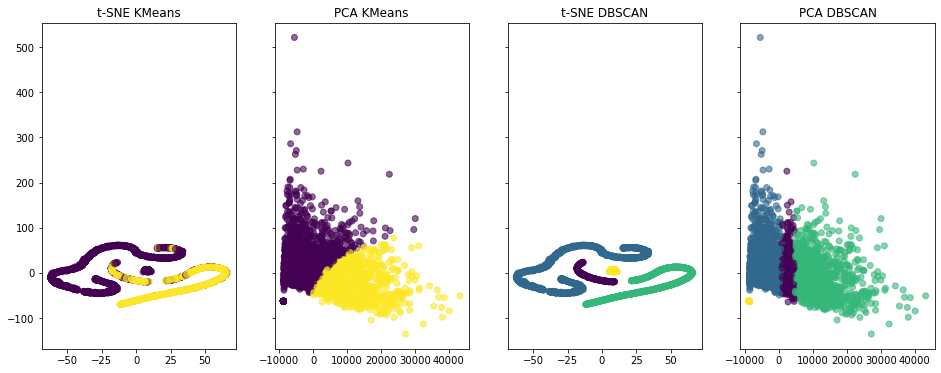

In [488]:
fig, axs = plt.subplots(1, 4, figsize=(16,6), sharey=True)

# Cluster the data in 2 groups with 2 methods (KMeans and DBSCAN)
labels_KMeans = KMeans(n_clusters=2, random_state=0).fit_predict(X) 
labels_DBSCAN = DBSCAN(eps=6).fit_predict(X_reduced_tsne)

# Plot the reduced data with t-SNE labeled by KMeans
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels_KMeans, alpha=0.6)
axs[0].set_title("t-SNE KMeans")

# Plot the reduced data with PCA labeled by KMeans
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels_KMeans, alpha=0.6)
axs[1].set_title("PCA KMeans") 

# Plot the reduced data with t-SNE labeled by DBSCAN
axs[2].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels_DBSCAN, alpha=0.6)
axs[2].set_title("t-SNE DBSCAN")

# Plot the reduced data with PCA labeled by DBSCAN
axs[3].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels_DBSCAN, alpha=0.6)
axs[3].set_title("PCA DBSCAN") 

plt.show()

In [520]:
def show_clusters(labels):
    """
    Show images of clusters

    Parameters
    ----------
    labels: array
        array of input labels
        for given clusters
    Returns
    ------- 
    """
    # for every cluster
    for cluster in np.unique(labels): 
        # calculate custer size
        cluster_size = sum(labels == cluster)
        print("### Cluster "+str(cluster)+" ### size: "+str(cluster_size)) 
        # show few pictures from every cluster
        fig, axs = plt.subplots(1, 5, figsize=(20,18), sharey=True)
        for index, i in enumerate(np.random.randint(cluster_size, size=min(5, cluster_size))):
            label_imgs = cv2.imread(df.img[i], cv2.IMREAD_GRAYSCALE) 
            axs[index].imshow(label_imgs) 
            axs[index].axis('off') 
            axs[index].plot()

### Cluster 0 ### size: 2425
### Cluster 1 ### size: 855


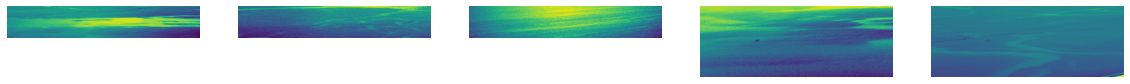

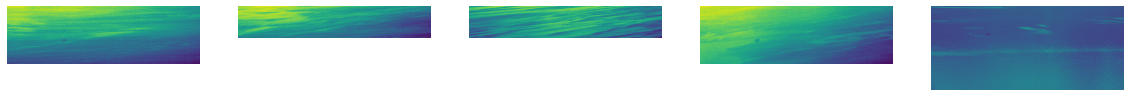

In [521]:
show_clusters(labels_KMeans)

### Cluster 0 ### size: 295
### Cluster 1 ### size: 1552
### Cluster 2 ### size: 893
### Cluster 3 ### size: 540


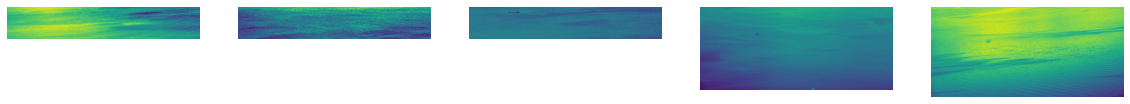

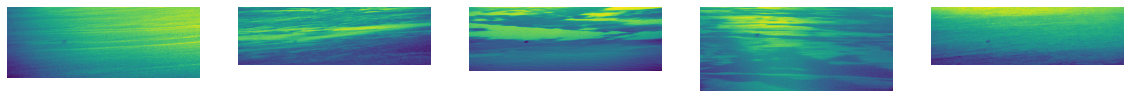

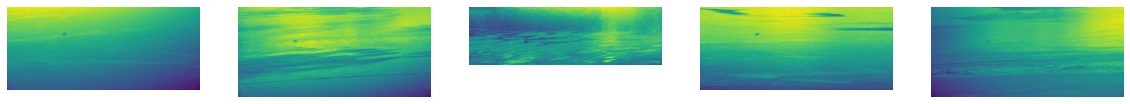

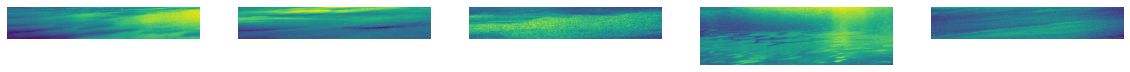

In [522]:
show_clusters(labels_DBSCAN)